### Imports

In [1]:
# modelagem e dados
import torch
from torchvision import transforms, datasets
from torch import nn, optim
from torch.utils import data


# avaliação de modelos
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# plotting e visualização
from torchsummary import summary
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# Transformar as imagens para tensores, para que possam ser utilizadas nas operações do pytorch
transform = transforms.ToTensor()

### Criando os datasets e dataloaders
Pegamos as imagens direto do pytorch, os dados de treino e de teste. Dividimos os dados de treino entre treino (85% do conjunto, para de fato treinar o modelo) e validação (para testarmos o quão bom está o treinamento, para identificarmos problemas como overfitting). Convertemos as imagens para tensores.

In [3]:
train_ds = datasets.MNIST(
    root = "/data/",
    train = True,
    download = True,
    transform = transform
)

length = len(train_ds)
len_val = int(0.15 * length)
len_train = length - len_val
train_ds, val_ds = data.random_split(train_ds, [len_train, len_val]) # aqui dividimos aleatoriamente o dataset

test_ds = datasets.MNIST(
    root = "/data/",
    train = False,
    download = True,
    transform = transform
)

In [4]:
# valores para o tamanho dos batches
BATCH_SIZE_TRAIN = 128
BATCH_SIZE_EVAL = 128

Aqui criamos os dataloaders, eles serão utilizados para iterarmos sobre os dados em conjuntos de 128 instâncias por vez. Calcularemos os gradientes e atualizaremos os pesos a cada batch. As imagens são aleatorizadas. Utilizamos 2 subprocessos e pin_memory=True (para evitar acessos ao disco), para agilizar o processamento.

In [5]:
train_dl = data.DataLoader(
    train_ds, batch_size=BATCH_SIZE_TRAIN, shuffle=True,
    num_workers=2, pin_memory=True
)

val_dl = data.DataLoader(
    val_ds, batch_size=BATCH_SIZE_EVAL, shuffle=True,
    num_workers=2, pin_memory=True
)

test_dl = data.DataLoader(
    test_ds, batch_size=BATCH_SIZE_EVAL, shuffle=True,
    num_workers=2, pin_memory=True
)

Cada instância de um dataloader consiste de 128 tensores, cada um com 1 canal (para indicar imagens em preto e branco), com dimensão 28x28

In [ ]:
instances, targets = next(iter(test_dl))
instances.shape, targets.shape

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(torch.Size([128, 1, 28, 28]), torch.Size([128]))

Visualizando algumas instâncias do dataset

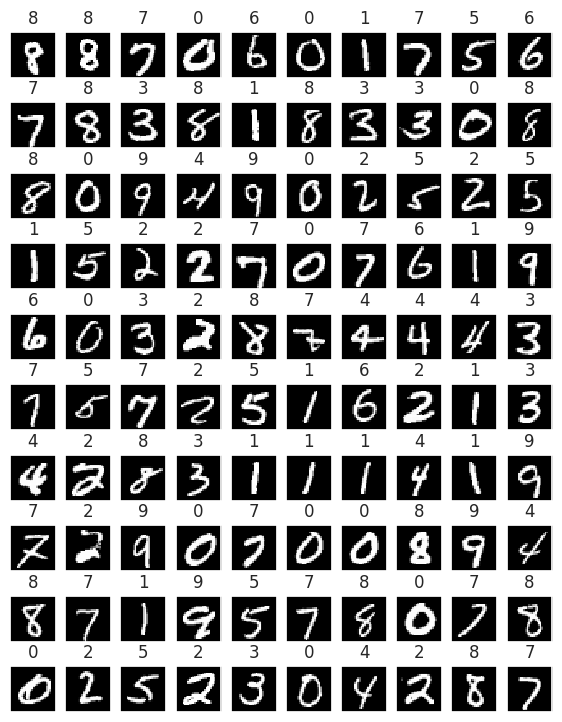

In [ ]:
w = 10
fig, ax = plt.subplots(w, w, figsize=(7, 9))
for i in range(w):
  for j in range(w):
    ax[i][j].imshow(instances[i * w + j].permute(1, 2, 0), cmap="gray", interpolation="None")
    label = targets[i * w + j].item()
    ax[i][j].set_title(label)
    ax[i][j].set_xticks([])
    ax[i][j].set_yticks([])

### Definindo os parâmetros iniciais

A primeira arquitetura do mlp será com uma camada oculta de 16 unidades de processamento, função de ativação sigmoid e 10 unidades na camada de output

In [170]:
class MLP(nn.Module):
  def __init__(self, n_classes):
    super().__init__()

    self.flatten = nn.Flatten() # converter os tensores 28x28 em tensores 784x1

    # aplica essas operações em sequência
    self.mlp = nn.Sequential(
        nn.Linear(784, 16),
        nn.Sigmoid(),
        nn.Linear(16, 10)
    )

  def forward(self, x):
    x_flat = self.flatten(x)
    logits = self.mlp(x_flat)
    return logits

Checando a disponibilidade da GPU

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [171]:
# instanciando o primeiro modelo
modelo = MLP(10).to(device)

Nos primeiros testes, utilizaremos:
- Loss Function: Cross Entropy
- Otimizador: SGD
- Learning Rate: 1
- Épocas: 20

In [ ]:
loss_fn = nn.CrossEntropyLoss()
LEARNING_RATE = 1.0
optimizer = optim.SGD(modelo.parameters(), lr=LEARNING_RATE)
EPOCHS = 20

Classe para podermos registrar o histórico de loss e posteriormente plotarmos

In [7]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

### Funções de treinamento e de validação

In [8]:
def train_step(model, train_dl, loss_fn, optimizer, device):
  # ativar modo de treino
  model.train()

  train_loss = AverageMeter()
  for train_instances, instance_labels in train_dl:
    # mover o lote e os rotulos para o mesmo dispositivo do modelo
    train_instances = train_instances.to(device)
    instance_labels = instance_labels.to(device)

    # fazer previsão com o modelo
    logits = model(train_instances)

    # zerar os gradientes para evitar acumular
    optimizer.zero_grad()

    # calcular função de perda
    loss = loss_fn(logits, instance_labels)
    train_loss.update(loss.item(), len(train_instances))

    # backpropagation para obter gradientes
    loss.backward()

    # aplicar a atualização dos parametros da rede baseado nos gradientes
    optimizer.step()
  return train_loss.avg

In [9]:
def validation_step(model, val_dl, loss_fn, device):
  # ativar modo de avaliação
  model.eval()

  val_loss = AverageMeter()
  # desativar computação de gradientes
  with torch.no_grad():
    for val_instances, instance_labels in val_dl:
      # mover o lote e os rotulos para o mesmo dispositivo do modelo
      val_instances = val_instances.to(device)
      instance_labels = instance_labels.to(device)

      # fazer previsão com o modelo
      logits = model(val_instances)

      # calcular função de perda
      loss = loss_fn(logits, instance_labels)
      val_loss.update(loss.item(), len(val_instances))
  return val_loss.avg

Dicionário para registrarmos a evolução da loss

In [ ]:
history = {
    "train_loss": [],
    "val_loss": []
}

### Execução do treinamento e validação do primeiro modelo

In [ ]:
for epoch in range(EPOCHS):
  train_loss = train_step(modelo, train_dl, loss_fn, optimizer, device)
  val_loss = validation_step(modelo, val_dl, loss_fn, device)

  history["train_loss"].append(train_loss)
  history["val_loss"].append(val_loss)

  print(f"Época [{epoch + 1}/{EPOCHS}]")
  print("-" * 35)
  print(f"Train loss: {round(train_loss, 6):<7}")
  print(f"Valid. loss: {round(val_loss, 6):<7}\n")

Época [1/20]
-----------------------------------
Train loss: 0.325116
Valid. loss: 0.277717

Época [2/20]
-----------------------------------
Train loss: 0.246821
Valid. loss: 0.234704

Época [3/20]
-----------------------------------
Train loss: 0.218275
Valid. loss: 0.227303

Época [4/20]
-----------------------------------
Train loss: 0.203379
Valid. loss: 0.225564

Época [5/20]
-----------------------------------
Train loss: 0.191835
Valid. loss: 0.209499

Época [6/20]
-----------------------------------
Train loss: 0.183745
Valid. loss: 0.213187

Época [7/20]
-----------------------------------
Train loss: 0.178331
Valid. loss: 0.207983

Época [8/20]
-----------------------------------
Train loss: 0.172257
Valid. loss: 0.203088

Época [9/20]
-----------------------------------
Train loss: 0.166737
Valid. loss: 0.207263

Época [10/20]
-----------------------------------
Train loss: 0.163048
Valid. loss: 0.218721

Época [11/20]
-----------------------------------
Train loss: 0.15899

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7aeaf5d120>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7e7aeaf5d120>

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
if w.is_alive():
      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    AssertionError: if w.is_alive():can only test a child process

  File "/usr/lib/

Época [17/20]
-----------------------------------
Train loss: 0.143039
Valid. loss: 0.2103 



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7aeaf5d120>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e7aeaf5d120>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Época [18/20]
-----------------------------------
Train loss: 0.141531
Valid. loss: 0.215702

Época [19/20]
-----------------------------------
Train loss: 0.138303
Valid. loss: 0.213452

Época [20/20]
-----------------------------------
Train loss: 0.136468
Valid. loss: 0.210848



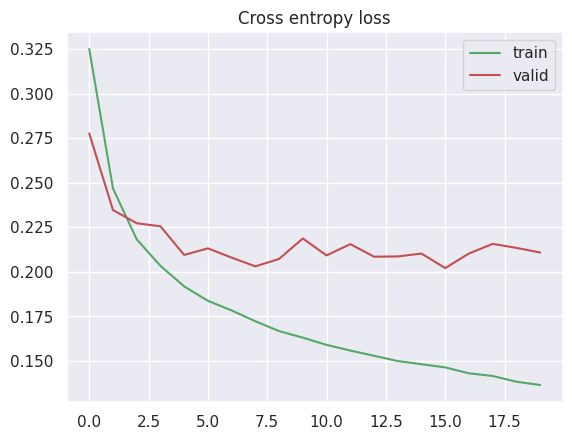

In [ ]:
fig = plt.figure()
plt.title("Cross entropy loss")
plt.plot(history["train_loss"], c="g", label="train")
plt.plot(history["val_loss"], c="r", label="valid")
plt.legend()

Observamos uma instabilidade na loss de validação, o que talvez indique que o modelo não está conseguindo generalizar bem, possívelmente por conta da alta learning rate, tentaremos diminuí-la no próxiom teste.

### 2o teste

In [ ]:
history = {
    "train_loss": [],
    "val_loss": []
}

In [ ]:
modelo3 = MLP(10).to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
LEARNING_RATE = 0.1     # dividindo o learning rate por 10
optimizer = optim.SGD(modelo3.parameters(), lr=LEARNING_RATE)
EPOCHS = 20

In [ ]:
for epoch in range(EPOCHS):
  train_loss = train_step(modelo3, train_dl, loss_fn, optimizer, device)
  val_loss = validation_step(modelo3, val_dl, loss_fn, device)

  history["train_loss"].append(train_loss)
  history["val_loss"].append(val_loss)

  print(f"Época [{epoch + 1}/{EPOCHS}]")
  print("-" * 35)
  print(f"Train loss: {round(train_loss, 6):<7}")
  print(f"Valid. loss: {round(val_loss, 6):<7}\n")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Época [1/20]
-----------------------------------
Train loss: 1.225327
Valid. loss: 0.643762

Época [2/20]
-----------------------------------
Train loss: 0.501929
Valid. loss: 0.429968

Época [3/20]
-----------------------------------
Train loss: 0.384645
Valid. loss: 0.368755

Época [4/20]
-----------------------------------
Train loss: 0.337543
Valid. loss: 0.332865

Época [5/20]
-----------------------------------
Train loss: 0.309703
Valid. loss: 0.306333

Época [6/20]
-----------------------------------
Train loss: 0.290076
Valid. loss: 0.289491

Época [7/20]
-----------------------------------
Train loss: 0.275243
Valid. loss: 0.277096

Época [8/20]
-----------------------------------
Train loss: 0.263271
Valid. loss: 0.266939

Época [9/20]
-----------------------------------
Train loss: 0.2532 
Valid. loss: 0.261405

Época [10/20]
-----------------------------------
Train loss: 0.244588
Valid. loss: 0.250306

Época [11/20]
-----------------------------------
Train loss: 0.237181

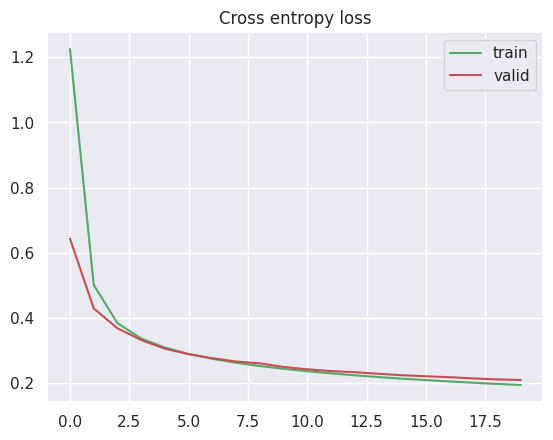

In [ ]:
fig = plt.figure()
plt.title("Cross entropy loss")
plt.plot(history["train_loss"], c="g", label="train")
plt.plot(history["val_loss"], c="r", label="valid")
plt.legend()

Com o aumento do learning rate, vimos que o modelo conseguiu generalizar bem melhor, tanto a curva de treinamento quanto a de validação ficaram mais suaves. Podemos tentar aumentar a quantidade de épocas para ver se o modelo consegue aprender mais.

### 3o teste

In [ ]:
history = {
    "train_loss": [],
    "val_loss": []
}

In [ ]:
modelo4 = MLP(10).to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
LEARNING_RATE = 0.1
optimizer = optim.SGD(modelo4.parameters(), lr=LEARNING_RATE)
EPOCHS = 30     # de 20 para 30 épocas

In [ ]:
for epoch in range(EPOCHS):
  train_loss = train_step(modelo4, train_dl, loss_fn, optimizer, device)
  val_loss = validation_step(modelo4, val_dl, loss_fn, device)

  history["train_loss"].append(train_loss)
  history["val_loss"].append(val_loss)

  print(f"Época [{epoch + 1}/{EPOCHS}]")
  print("-" * 35)
  print(f"Train loss: {round(train_loss, 6):<7}")
  print(f"Valid. loss: {round(val_loss, 6):<7}\n")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Época [1/30]
-----------------------------------
Train loss: 1.223943
Valid. loss: 0.629746

Época [2/30]
-----------------------------------
Train loss: 0.491022
Valid. loss: 0.412617

Época [3/30]
-----------------------------------
Train loss: 0.372859
Valid. loss: 0.347256

Época [4/30]
-----------------------------------
Train loss: 0.326638
Valid. loss: 0.315927

Época [5/30]
-----------------------------------
Train loss: 0.299748
Valid. loss: 0.294101

Época [6/30]
-----------------------------------
Train loss: 0.280855
Valid. loss: 0.280145

Época [7/30]
-----------------------------------
Train loss: 0.266158
Valid. loss: 0.268013

Época [8/30]
-----------------------------------
Train loss: 0.25403
Valid. loss: 0.259957

Época [9/30]
-----------------------------------
Train loss: 0.244119
Valid. loss: 0.249776

Época [10/30]
-----------------------------------
Train loss: 0.235249
Valid. loss: 0.242391

Época [11/30]
-----------------------------------
Train loss: 0.227215

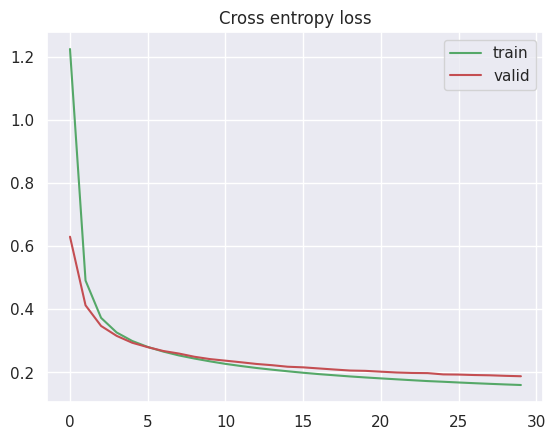

In [ ]:
fig = plt.figure()
plt.title("Cross entropy loss")
plt.plot(history["train_loss"], c="g", label="train")
plt.plot(history["val_loss"], c="r", label="valid")
plt.legend()

Embora as curvas estejam se separando, a loss de validação ainda está diminuindo, está diminuindo mais lentamente que a de treino, mas isso não é um problema, visto que o modelo ainda está conseguindo melhorar a capacidade de generalização. Podemos testar diminuir ainda mais a learning rate.

### 4o teste

In [ ]:
history = {
    "train_loss": [],
    "val_loss": []
}

In [ ]:
modelo5 = MLP(10).to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
LEARNING_RATE = 0.01    # 0.1 -> 0.01
optimizer = optim.SGD(modelo5.parameters(), lr=LEARNING_RATE)
EPOCHS = 30

In [ ]:
for epoch in range(EPOCHS):
  train_loss = train_step(modelo5, train_dl, loss_fn, optimizer, device)
  val_loss = validation_step(modelo5, val_dl, loss_fn, device)

  history["train_loss"].append(train_loss)
  history["val_loss"].append(val_loss)

  print(f"Época [{epoch + 1}/{EPOCHS}]")
  print("-" * 35)
  print(f"Train loss: {round(train_loss, 6):<7}")
  print(f"Valid. loss: {round(val_loss, 6):<7}\n")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Época [1/30]
-----------------------------------
Train loss: 2.210698
Valid. loss: 2.098035

Época [2/30]
-----------------------------------
Train loss: 1.947562
Valid. loss: 1.785801

Época [3/30]
-----------------------------------
Train loss: 1.62287
Valid. loss: 1.471311

Época [4/30]
-----------------------------------
Train loss: 1.341893
Valid. loss: 1.228286

Época [5/30]
-----------------------------------
Train loss: 1.131401
Valid. loss: 1.048655

Época [6/30]
-----------------------------------
Train loss: 0.974298
Valid. loss: 0.913163

Época [7/30]
-----------------------------------
Train loss: 0.854986
Valid. loss: 0.809912

Época [8/30]
-----------------------------------
Train loss: 0.763543
Valid. loss: 0.730305

Época [9/30]
-----------------------------------
Train loss: 0.692744
Valid. loss: 0.668195

Época [10/30]
-----------------------------------
Train loss: 0.637128
Valid. loss: 0.619081

Época [11/30]
-----------------------------------
Train loss: 0.592583

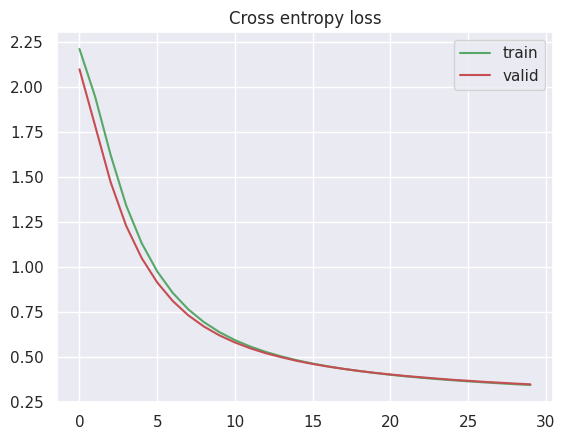

In [ ]:
fig = plt.figure()
plt.title("Cross entropy loss")
plt.plot(history["train_loss"], c="g", label="train")
plt.plot(history["val_loss"], c="r", label="valid")
plt.legend()

Conseguimos deixar as curvas mais juntas, mas a loss não diminuiu tanto, como diminuimos a learning rate, é bom que aumentemos a quantidade de épocas.

### 5o teste

In [ ]:
history = {
    "train_loss": [],
    "val_loss": []
}

In [ ]:
modelo8 = MLP(10).to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
LEARNING_RATE = 0.01
optimizer = optim.SGD(modelo8.parameters(), lr=LEARNING_RATE)
EPOCHS = 300    # 30 -> 300

In [ ]:
for epoch in range(EPOCHS):
  train_loss = train_step(modelo8, train_dl, loss_fn, optimizer, device)
  val_loss = validation_step(modelo8, val_dl, loss_fn, device)

  history["train_loss"].append(train_loss)
  history["val_loss"].append(val_loss)

  print(f"Época [{epoch + 1}/{EPOCHS}]")
  print("-" * 35)
  print(f"Train loss: {round(train_loss, 6):<7}")
  print(f"Valid. loss: {round(val_loss, 6):<7}\n")

Época [1/300]
-----------------------------------
Train loss: 2.209006
Valid. loss: 2.094315

Época [2/300]
-----------------------------------
Train loss: 1.936761
Valid. loss: 1.764137

Época [3/300]
-----------------------------------
Train loss: 1.589121
Valid. loss: 1.426124

Época [4/300]
-----------------------------------
Train loss: 1.290483
Valid. loss: 1.17089

Época [5/300]
-----------------------------------
Train loss: 1.075185
Valid. loss: 0.99191

Época [6/300]
-----------------------------------
Train loss: 0.924143
Valid. loss: 0.86589

Época [7/300]
-----------------------------------
Train loss: 0.816289
Valid. loss: 0.774416

Época [8/300]
-----------------------------------
Train loss: 0.736639
Valid. loss: 0.706075

Época [9/300]
-----------------------------------
Train loss: 0.675937
Valid. loss: 0.653386

Época [10/300]
-----------------------------------
Train loss: 0.628237
Valid. loss: 0.610749

Época [11/300]
-----------------------------------
Train loss:

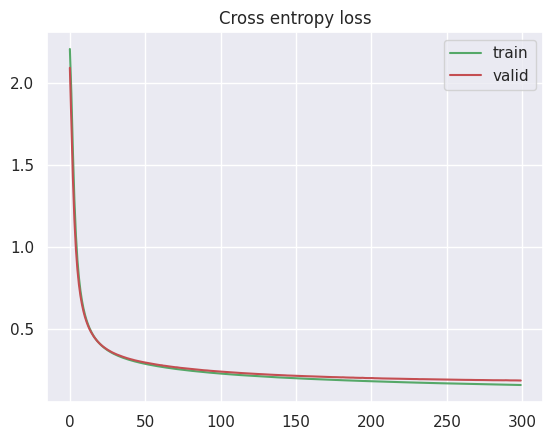

In [ ]:
fig = plt.figure()
plt.title("Cross entropy loss")
plt.plot(history["train_loss"], c="g", label="train")
plt.plot(history["val_loss"], c="r", label="valid")
plt.legend()

Com um learning rate de 0.001 em vez de 0.01, precisamos de 300 épocas para obter a mesma loss de validação que conseguimos com 30 épocas. Podemos tentar algumas modificações para diminuir a quantidade de épocas necessárias para treinar o modelo, como o algoritmo de otimização (utilizar o ADAM, por exemplo, que faz uso de momentum para convergir mais rapidamente) ou a função de ativação (a função sigmoide pode facilmente estagnar quando a sua saída se aproxima de 0 ou de 1, já que a derivada se aproxima de 0, além de ter como valor máximo 0.25, fazendo com que no geral os gradientes sejam pequenos, levando a um aprendizado mais lento, podendo até ter vanishing gradients em uma rede com várias camadas). Tentaremos trocar a função de ativação para o ReLU.

### 6o teste

In [14]:
class MLPR(nn.Module):
  def __init__(self, n_classes):
    super().__init__()

    self.flatten = nn.Flatten()

    self.mlp = nn.Sequential(
        nn.Linear(784, 16),
        nn.ReLU(),  # sigmoide -> ReLU
        nn.Linear(16, 10)
    )

  def forward(self, x):
    x_flat = self.flatten(x)
    logits = self.mlp(x_flat)
    return logits

In [ ]:
history = {
    "train_loss": [],
    "val_loss": []
}

In [ ]:
modelo9 = MLPR(10).to(device)

In [ ]:
# mesmos hiper parametros
loss_fn = nn.CrossEntropyLoss()
LEARNING_RATE = 0.01
optimizer = optim.SGD(modelo9.parameters(), lr=LEARNING_RATE)
EPOCHS = 300

In [ ]:
for epoch in range(EPOCHS):
  train_loss = train_step(modelo9, train_dl, loss_fn, optimizer, device)
  val_loss = validation_step(modelo9, val_dl, loss_fn, device)

  history["train_loss"].append(train_loss)
  history["val_loss"].append(val_loss)

  print(f"Época [{epoch + 1}/{EPOCHS}]")
  print("-" * 35)
  print(f"Train loss: {round(train_loss, 6):<7}")
  print(f"Valid. loss: {round(val_loss, 6):<7}\n")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Época [1/300]
-----------------------------------
Train loss: 1.473616
Valid. loss: 0.810745

Época [2/300]
-----------------------------------
Train loss: 0.611967
Valid. loss: 0.505951

Época [3/300]
-----------------------------------
Train loss: 0.451971
Valid. loss: 0.419061

Época [4/300]
-----------------------------------
Train loss: 0.394072
Valid. loss: 0.377642

Época [5/300]
-----------------------------------
Train loss: 0.364312
Valid. loss: 0.355665

Época [6/300]
-----------------------------------
Train loss: 0.345045
Valid. loss: 0.340298

Época [7/300]
-----------------------------------
Train loss: 0.331366
Valid. loss: 0.328618

Época [8/300]
-----------------------------------
Train loss: 0.320502
Valid. loss: 0.32045

Época [9/300]
-----------------------------------
Train loss: 0.311689
Valid. loss: 0.312309

Época [10/300]
-----------------------------------
Train loss: 0.304112
Valid. loss: 0.306613

Época [11/300]
-----------------------------------
Train los

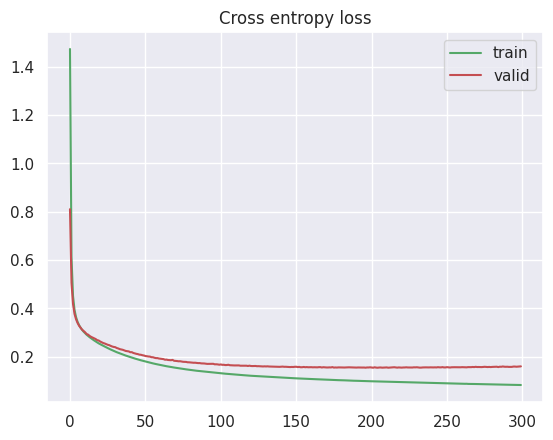

In [ ]:
fig = plt.figure()
plt.title("Cross entropy loss")
plt.plot(history["train_loss"], c="g", label="train")
plt.plot(history["val_loss"], c="r", label="valid")
plt.legend()

Observamos uma convergência bem mais rápida, chegamos na mesma loss de 300 épocas utilizando sigmoide com apenas 64, conseguindo diminuir ainda mais, até a casa de 0.15, mas por conta da grande quantidade de épocas, acabamos com overfitting. Observe que a loss de validação começa a aumentar, indicando que o modelo está perdendo capacidade de generalização, enquanto que a loss de treinamento está aumentando. Podemos fazer um early stopping para tentar evitar o processo de overfitting e também podemos testar mudar a inicialização dos pesos, utilizando algo mais adequado para a função de ativação ReLU: He/Kaiming initialization.

### 7o teste

In [9]:
history = {
    "train_loss": [],
    "val_loss": []
}

In [15]:
modelo10 = MLPR(10).to(device)

In [12]:
import torch.nn.init as init

Testamos 2 variações de He/Kaiming initialization que o pytorch fornece, essa acabou sendo a melhor; também setamos os bias para começarem em 0, como recomendado para esse modelo de inicialização.

In [16]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            m.bias.data.fill_(0.0)

modelo10.apply(init_weights)

MLPR(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [16]:
loss_fn = nn.CrossEntropyLoss()
LEARNING_RATE = 0.01
optimizer = optim.SGD(modelo10.parameters(), lr=LEARNING_RATE)
EPOCHS = 150    # 300 -> 150

In [18]:
for epoch in range(EPOCHS):
  train_loss = train_step(modelo10, train_dl, loss_fn, optimizer, device)
  val_loss = validation_step(modelo10, val_dl, loss_fn, device)

  history["train_loss"].append(train_loss)
  history["val_loss"].append(val_loss)

  print(f"Época [{epoch + 1}/{EPOCHS}]")
  print("-" * 35)
  print(f"Train loss: {round(train_loss, 6):<7}")
  print(f"Valid. loss: {round(val_loss, 6):<7}\n")

Época [1/150]
-----------------------------------
Train loss: 1.491998
Valid. loss: 0.95521

Época [2/150]
-----------------------------------
Train loss: 0.756124
Valid. loss: 0.639636

Época [3/150]
-----------------------------------
Train loss: 0.556296
Valid. loss: 0.514748

Época [4/150]
-----------------------------------
Train loss: 0.46675
Valid. loss: 0.45206

Época [5/150]
-----------------------------------
Train loss: 0.417932
Valid. loss: 0.414214

Época [6/150]
-----------------------------------
Train loss: 0.386859
Valid. loss: 0.391429

Época [7/150]
-----------------------------------
Train loss: 0.365798
Valid. loss: 0.371046

Época [8/150]
-----------------------------------
Train loss: 0.349835
Valid. loss: 0.35832

Época [9/150]
-----------------------------------
Train loss: 0.33713
Valid. loss: 0.347833

Época [10/150]
-----------------------------------
Train loss: 0.326924
Valid. loss: 0.337887

Época [11/150]
-----------------------------------
Train loss: 0

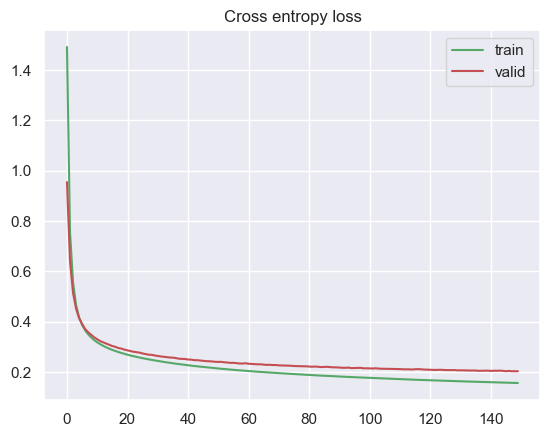

In [19]:
fig = plt.figure()
plt.title("Cross entropy loss")
plt.plot(history["train_loss"], c="g", label="train")
plt.plot(history["val_loss"], c="r", label="valid")
plt.legend()

Mudando o tipo de inicialização, observamos uma loss maior que a inicialização antiga, um aprendizado mais lento por parte do modelo. Isso não é surpreendente, uma vez que tal inicialização se destaca quando temos redes mais profundas e complexas, evitando problemas como vanishing ou exploding gradients. Outra coisa que podemos observar, é que a loss inicial com esse método acaba sendo maior, o que também faz com que o modelo demore um pouco mais a convergir. É importante notar também que inicializações podem alterar a maneira que navega-se pela superfície de loss, desejando-se evitar mínimos locais, ou platôs, fazendo com que a convergência possívelmente seja mais lenta. De qualquer maneira, é interessante aumentar a complexidade da rede, para tiramos melhor proveito da inicialização e melhorarmos a capacidade do modelo de modelar padrões.

### 8o teste

In [21]:
class MLPR2(nn.Module):
  def __init__(self, n_classes):
    super().__init__() 

    self.flatten = nn.Flatten()

    # adicionamos uma camada intermediária com 32 neurônios, como camada inicial
    self.mlp = nn.Sequential(
        nn.Linear(784, 32),
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 10)
    )

  def forward(self, x):
    x_flat = self.flatten(x)
    logits = self.mlp(x_flat)
    return logits

In [23]:
modelo11 = MLPR2(10).to(device)
modelo11.apply(init_weights)

MLPR2(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [26]:
loss_fn = nn.CrossEntropyLoss()
LEARNING_RATE = 0.01
optimizer = optim.SGD(modelo11.parameters(), lr=LEARNING_RATE)
EPOCHS = 150

In [27]:
for epoch in range(EPOCHS):
  train_loss = train_step(modelo11, train_dl, loss_fn, optimizer, device)
  val_loss = validation_step(modelo11, val_dl, loss_fn, device)

  history["train_loss"].append(train_loss)
  history["val_loss"].append(val_loss)

  print(f"Época [{epoch + 1}/{EPOCHS}]")
  print("-" * 35)
  print(f"Train loss: {round(train_loss, 6):<7}")
  print(f"Valid. loss: {round(val_loss, 6):<7}\n")

Época [1/150]
-----------------------------------
Train loss: 1.459826
Valid. loss: 0.851655

Época [2/150]
-----------------------------------
Train loss: 0.623138
Valid. loss: 0.511008

Época [3/150]
-----------------------------------
Train loss: 0.448117
Valid. loss: 0.420079

Época [4/150]
-----------------------------------
Train loss: 0.386998
Valid. loss: 0.37837

Época [5/150]
-----------------------------------
Train loss: 0.354176
Valid. loss: 0.350441

Época [6/150]
-----------------------------------
Train loss: 0.3316 
Valid. loss: 0.331844

Época [7/150]
-----------------------------------
Train loss: 0.315324
Valid. loss: 0.315781

Época [8/150]
-----------------------------------
Train loss: 0.301293
Valid. loss: 0.303701

Época [9/150]
-----------------------------------
Train loss: 0.289897
Valid. loss: 0.295007

Época [10/150]
-----------------------------------
Train loss: 0.279899
Valid. loss: 0.284989

Época [11/150]
-----------------------------------
Train loss

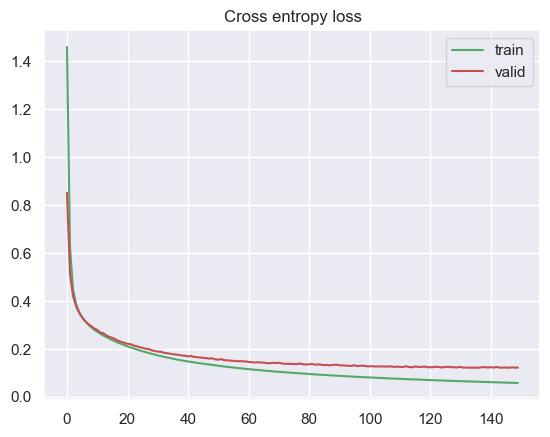

In [37]:
fig = plt.figure()
plt.title("Cross entropy loss")
plt.plot(history["train_loss"][153::5], c="g", label="train")
plt.plot(history["val_loss"][153::5], c="r", label="valid")
plt.legend()

O modelo melhorou bastante na sua capacidade de aprendizado, indo de uma loss de validação de 0.20 para 0.12. Porém, não obtivemos melhoria significante após algumas épocas, podemos testar early stopping, e podemos testar também aumentar ainda mais a complexidade da rede.

### 9o teste

In [45]:
class MLPR3(nn.Module):
  def __init__(self, n_classes):
    super().__init__() # necessário sempre

    self.flatten = nn.Flatten()

    # adicionamos uma camada de 64 neuronios no começo
    self.mlp = nn.Sequential(
        nn.Linear(784, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 10)
    )

  # Esse método é necessário. Executada o passo feed-forward da computação da
  # rede neural.
  def forward(self, x):
    x_flat = self.flatten(x)
    logits = self.mlp(x_flat)
    return logits

In [48]:
history = {
    "train_loss": [],
    "val_loss": []
}

In [46]:
modelo12 = MLPR3(10).to(device)
modelo12.apply(init_weights)

MLPR3(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [47]:
loss_fn = nn.CrossEntropyLoss()
LEARNING_RATE = 0.01
optimizer = optim.SGD(modelo12.parameters(), lr=LEARNING_RATE)
EPOCHS = 150    # por enquanto manteremos a quantidade de épocas

In [49]:
for epoch in range(EPOCHS):
  train_loss = train_step(modelo12, train_dl, loss_fn, optimizer, device)
  val_loss = validation_step(modelo12, val_dl, loss_fn, device)

  history["train_loss"].append(train_loss)
  history["val_loss"].append(val_loss)

  print(f"Época [{epoch + 1}/{EPOCHS}]")
  print("-" * 35)
  print(f"Train loss: {round(train_loss, 6):<7}")
  print(f"Valid. loss: {round(val_loss, 6):<7}\n")

Época [1/150]
-----------------------------------
Train loss: 1.443289
Valid. loss: 0.905976

Época [2/150]
-----------------------------------
Train loss: 0.679853
Valid. loss: 0.52374

Época [3/150]
-----------------------------------
Train loss: 0.440955
Valid. loss: 0.40124

Época [4/150]
-----------------------------------
Train loss: 0.362095
Valid. loss: 0.351737

Época [5/150]
-----------------------------------
Train loss: 0.321193
Valid. loss: 0.321511

Época [6/150]
-----------------------------------
Train loss: 0.293342
Valid. loss: 0.293865

Época [7/150]
-----------------------------------
Train loss: 0.271821
Valid. loss: 0.279623

Época [8/150]
-----------------------------------
Train loss: 0.254218
Valid. loss: 0.257144

Época [9/150]
-----------------------------------
Train loss: 0.239904
Valid. loss: 0.248443

Época [10/150]
-----------------------------------
Train loss: 0.227208
Valid. loss: 0.235745

Época [11/150]
-----------------------------------
Train loss

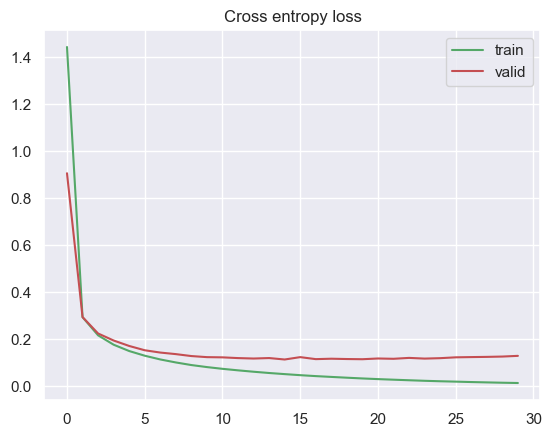

In [51]:
fig = plt.figure()
plt.title("Cross entropy loss")
plt.plot(history["train_loss"][::5], c="g", label="train")
plt.plot(history["val_loss"][::5], c="r", label="valid")
plt.legend()

Antigimos o loss mínimo bem mais rápido que na arquitetura anterior, porém observamos overfitting, após a época 60, por volta de onde conseguimos o mínimo de 0.11 de loss, a loss de validação começou a aumentar, enquanto a loss de treino diminuía, evidenciando um caso de overfitting e mostrando que podemos inserir alguma técnica de regularização ou fazer early stopping. Testaremos mudar o otimizador para o Adam, para uma convergência mais rápida. Porém, a princípio provavelmente teremos um declínio no desempenho, já que precisaremos ajustar os hiperparametros para o otimizador (como a learning rate, que deve ser diferente do valor utilizado no SGD).

### 10o teste

In [56]:
history = {
    "train_loss": [],
    "val_loss": []
}

In [57]:
modelo13 = MLPR3(10).to(device)
modelo13.apply(init_weights)

MLPR3(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [59]:
loss_fn = nn.CrossEntropyLoss()
LEARNING_RATE = 0.001
optimizer = optim.Adam(modelo13.parameters(), lr=LEARNING_RATE) # sgd -> adam
EPOCHS = 30

In [60]:
for epoch in range(EPOCHS):
  train_loss = train_step(modelo13, train_dl, loss_fn, optimizer, device)
  val_loss = validation_step(modelo13, val_dl, loss_fn, device)

  history["train_loss"].append(train_loss)
  history["val_loss"].append(val_loss)

  print(f"Época [{epoch + 1}/{EPOCHS}]")
  print("-" * 35)
  print(f"Train loss: {round(train_loss, 6):<7}")
  print(f"Valid. loss: {round(val_loss, 6):<7}\n")

Época [1/30]
-----------------------------------
Train loss: 0.515341
Valid. loss: 0.23477

Época [2/30]
-----------------------------------
Train loss: 0.190445
Valid. loss: 0.179523

Época [3/30]
-----------------------------------
Train loss: 0.142615
Valid. loss: 0.146998

Época [4/30]
-----------------------------------
Train loss: 0.115945
Valid. loss: 0.12685

Época [5/30]
-----------------------------------
Train loss: 0.096257
Valid. loss: 0.118701

Época [6/30]
-----------------------------------
Train loss: 0.082439
Valid. loss: 0.114958

Época [7/30]
-----------------------------------
Train loss: 0.071137
Valid. loss: 0.11356

Época [8/30]
-----------------------------------
Train loss: 0.06541
Valid. loss: 0.106417

Época [9/30]
-----------------------------------
Train loss: 0.05567
Valid. loss: 0.10896

Época [10/30]
-----------------------------------
Train loss: 0.051221
Valid. loss: 0.102762

Época [11/30]
-----------------------------------
Train loss: 0.045492
Vali

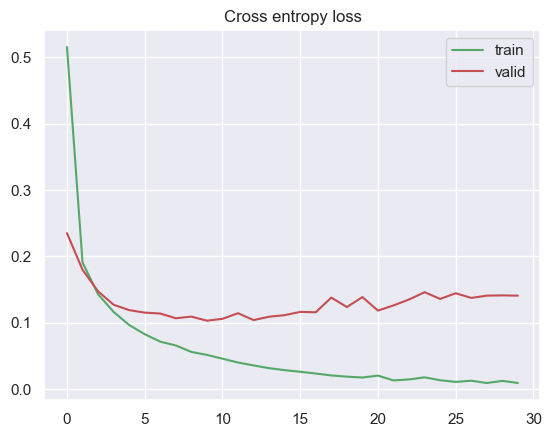

In [62]:
fig = plt.figure()
plt.title("Cross entropy loss")
plt.plot(history["train_loss"], c="g", label="train")
plt.plot(history["val_loss"], c="r", label="valid")
plt.legend()

Como era possível, ficamos com uma variação de loss muito instável, possívelmente passos muito longos durante a otimização, tentaremos dividir a learning rate por 10. Possivelmente a convergência demorará um pouco mais, então também aumentaremos a quantidade de épocas.

### 11o teste

In [65]:
history = {
    "train_loss": [],
    "val_loss": []
}

modelo14 = MLPR3(10).to(device)
modelo14.apply(init_weights)

LEARNING_RATE = 0.0001   # 0.001 -> 0.0001
optimizer = optim.Adam(modelo14.parameters(), lr=LEARNING_RATE)
EPOCHS = 60     # 30 -> 60

for epoch in range(EPOCHS):
  train_loss = train_step(modelo14, train_dl, loss_fn, optimizer, device)
  val_loss = validation_step(modelo14, val_dl, loss_fn, device)

  history["train_loss"].append(train_loss)
  history["val_loss"].append(val_loss)

  print(f"Época [{epoch + 1}/{EPOCHS}]")
  print("-" * 35)
  print(f"Train loss: {round(train_loss, 6):<7}")
  print(f"Valid. loss: {round(val_loss, 6):<7}\n")

Época [1/60]
-----------------------------------
Train loss: 1.397453
Valid. loss: 0.68831

Época [2/60]
-----------------------------------
Train loss: 0.508027
Valid. loss: 0.411548

Época [3/60]
-----------------------------------
Train loss: 0.355365
Valid. loss: 0.329247

Época [4/60]
-----------------------------------
Train loss: 0.293914
Valid. loss: 0.285576

Época [5/60]
-----------------------------------
Train loss: 0.25786
Valid. loss: 0.258313

Época [6/60]
-----------------------------------
Train loss: 0.232757
Valid. loss: 0.238721

Época [7/60]
-----------------------------------
Train loss: 0.213374
Valid. loss: 0.223618

Época [8/60]
-----------------------------------
Train loss: 0.198488
Valid. loss: 0.21042

Época [9/60]
-----------------------------------
Train loss: 0.185823
Valid. loss: 0.200845

Época [10/60]
-----------------------------------
Train loss: 0.175538
Valid. loss: 0.195386

Época [11/60]
-----------------------------------
Train loss: 0.166393
V

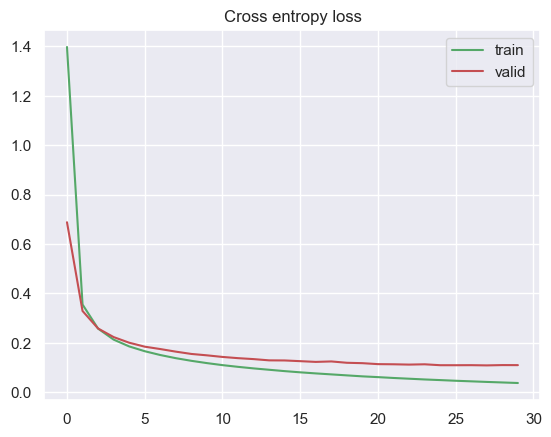

In [67]:
fig = plt.figure()
plt.title("Cross entropy loss")
plt.plot(history["train_loss"][::2], c="g", label="train")
plt.plot(history["val_loss"][::2], c="r", label="valid")
plt.legend()

Com essa redução no learning rate, obtivemos uma melhoria considerável tanto na velocidade de convergência, quanto no valor da loss. Chegamos em 0.11 em apenas 36 épocas, e em um mínimo de 0.10! Agora vamos testar como esse modelo está em relação a algumas métricas, primeiro faremos predições utilizando o conjunto de **validação**

In [81]:
all_probs = []
all_preds = []
all_targets = []

total_corrects = 0
total_n = 0

# modelo para modo de avaliação
modelo14.eval()
for val_instances, val_labels in val_dl:
    # mover o lote e os rotulos para o mesmo dispositivo do modelo
    val_instances = val_instances.to(device)
    val_labels = val_labels.to(device)

    # desativar computação de gradientes
    with torch.no_grad():
        # fazer previsão com o modelo
        logits = modelo14(val_instances)
    
    # calcular probabilidades e previsões
    probabilities = nn.functional.softmax(logits, 1)
    preds = torch.argmax(probabilities, 1)

    # calcular acurácia
    total_corrects += (preds == val_labels).sum().item()
    total_n += len(val_instances)

    # salvar probabilidades, previsões e rótulos
    all_probs.append(probabilities.cpu())
    all_preds.append(preds.unsqueeze(-1))
    all_targets.append(val_labels.cpu())


preds = torch.cat(all_preds).cpu()
targets = torch.cat(all_targets).cpu()

print(f"Preds Shape: {preds.shape}")
print(f"Targets Shape: {targets.shape}")

Preds Shape: torch.Size([9000, 1])
Targets Shape: torch.Size([9000])


Matriz de confusão, podemos observar a quantidade de erros e em relação de erro entre cada classe. Podemos observar uma quantidade bem menor de exemplos em relação à classe "5", possivelmente na distribuição dos datasets o conjunto de validação ficou com uma quantidade menor de instâncias da classe 5. Podemos observar também uma quantidade maior de erros na classe "9", com valores sendo previstos incorretamente como "3" e "4".

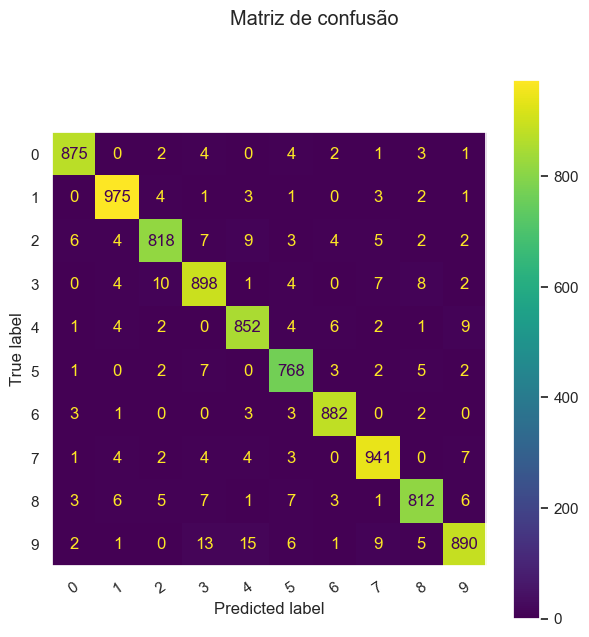

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
fig.suptitle("Matriz de confusão")
ax.grid(False)

labels = list(str(i) for i in range(10))

cm = confusion_matrix(targets, preds)
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels)
cm_display.plot(ax=ax, xticks_rotation=35.0)

Conseguimos boas métricas para o modelo, mas ainda podemos tentar melhorar (acabei apagando a célula e agora já não tenho mais no histórico, mas acredito que a precisão foi de 0.973 ou 0.974)

In [83]:
print(classification_report(targets, preds, target_names=labels, zero_division=0))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       892
           1       0.98      0.98      0.98       990
           2       0.97      0.95      0.96       860
           3       0.95      0.96      0.96       934
           4       0.96      0.97      0.96       881
           5       0.96      0.97      0.96       790
           6       0.98      0.99      0.98       894
           7       0.97      0.97      0.97       966
           8       0.97      0.95      0.96       851
           9       0.97      0.94      0.96       942

    accuracy                           0.97      9000
   macro avg       0.97      0.97      0.97      9000
weighted avg       0.97      0.97      0.97      9000



### 12o teste

Podemos inserir regularização do tipo weight_decay para testar os resultados

In [93]:
history = {
    "train_loss": [],
    "val_loss": []
}

modelo15 = MLPR3(10).to(device)
modelo15.apply(init_weights)

LEARNING_RATE = 0.001
optimizer = optim.Adam(modelo15.parameters(), lr=LEARNING_RATE, weight_decay=1e-3) # adicionando regularização
EPOCHS = 30

for epoch in range(EPOCHS):
  train_loss = train_step(modelo15, train_dl, loss_fn, optimizer, device)
  val_loss = validation_step(modelo15, val_dl, loss_fn, device)

  history["train_loss"].append(train_loss)
  history["val_loss"].append(val_loss)

  print(f"Época [{epoch + 1}/{EPOCHS}]")
  print("-" * 35)
  print(f"Train loss: {round(train_loss, 6):<7}")
  print(f"Valid. loss: {round(val_loss, 6):<7}\n")

Época [1/30]
-----------------------------------
Train loss: 0.477331
Valid. loss: 0.248525

Época [2/30]
-----------------------------------
Train loss: 0.186252
Valid. loss: 0.180374

Época [3/30]
-----------------------------------
Train loss: 0.144208
Valid. loss: 0.147198

Época [4/30]
-----------------------------------
Train loss: 0.119409
Valid. loss: 0.138012

Época [5/30]
-----------------------------------
Train loss: 0.105668
Valid. loss: 0.127434

Época [6/30]
-----------------------------------
Train loss: 0.094504
Valid. loss: 0.127598

Época [7/30]
-----------------------------------
Train loss: 0.086493
Valid. loss: 0.122018

Época [8/30]
-----------------------------------
Train loss: 0.081992
Valid. loss: 0.106145

Época [9/30]
-----------------------------------
Train loss: 0.07794
Valid. loss: 0.110066

Época [10/30]
-----------------------------------
Train loss: 0.068877
Valid. loss: 0.099623

Época [11/30]
-----------------------------------
Train loss: 0.0667 


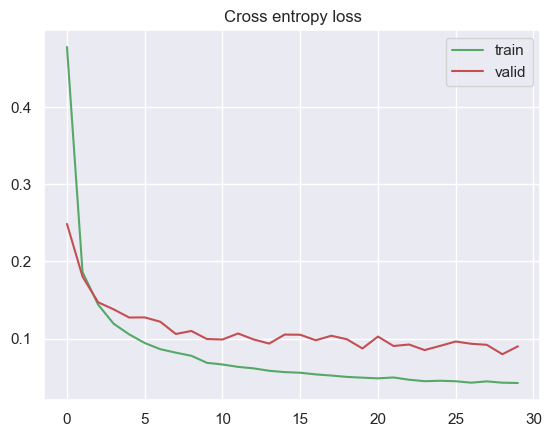

In [94]:
fig = plt.figure()
plt.title("Cross entropy loss")
plt.plot(history["train_loss"], c="g", label="train")
plt.plot(history["val_loss"], c="r", label="valid")
plt.legend()

In [95]:
all_probs = []
all_preds = []
all_targets = []

total_corrects = 0
total_n = 0
modelo15.eval()
for val_instances, val_labels in val_dl:
    val_instances = val_instances.to(device)
    val_labels = val_labels.to(device)

    with torch.no_grad():
        logits = modelo15(val_instances)
    probabilities = nn.functional.softmax(logits, 1)
    all_probs.append(probabilities.cpu())
    preds = torch.argmax(probabilities, 1)

    total_corrects += (preds == val_labels).sum().item()
    total_n += len(val_instances)

    all_preds.append(preds.unsqueeze(-1))
    all_targets.append(val_labels.cpu())


preds = torch.cat(all_preds).cpu()
targets = torch.cat(all_targets).cpu()

print(f"Preds Shape: {preds.shape}")
print(f"Targets Shape: {targets.shape}")

Preds Shape: torch.Size([9000, 1])
Targets Shape: torch.Size([9000])


In [96]:
total_corrects/total_n

0.9726666666666667

In [97]:
print(classification_report(targets, preds, target_names=labels, zero_division=0))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       892
           1       0.98      0.99      0.99       990
           2       0.97      0.97      0.97       860
           3       0.97      0.97      0.97       934
           4       0.99      0.95      0.97       881
           5       0.95      0.97      0.96       790
           6       0.98      0.99      0.98       894
           7       0.99      0.97      0.98       966
           8       0.97      0.95      0.96       851
           9       0.94      0.98      0.96       942

    accuracy                           0.97      9000
   macro avg       0.97      0.97      0.97      9000
weighted avg       0.97      0.97      0.97      9000



Embora a loss validation ficou menor, a precisão ficou levemente menor (cerca de 0.001), podemos testar o weight_decay com um valor diferente.

### 13o teste

In [108]:
history = {
    "train_loss": [],
    "val_loss": []
}

modelo16 = MLPR3(10).to(device)
modelo16.apply(init_weights)

LEARNING_RATE = 0.001
optimizer = optim.Adam(modelo16.parameters(), lr=LEARNING_RATE, weight_decay=1e-4) # 1e-3 -> 1e-4
EPOCHS = 30

for epoch in range(EPOCHS):
  train_loss = train_step(modelo16, train_dl, loss_fn, optimizer, device)
  val_loss = validation_step(modelo16, val_dl, loss_fn, device)

  history["train_loss"].append(train_loss)
  history["val_loss"].append(val_loss)

  print(f"Época [{epoch + 1}/{EPOCHS}]")
  print("-" * 35)
  print(f"Train loss: {round(train_loss, 6):<7}")
  print(f"Valid. loss: {round(val_loss, 6):<7}\n")

Época [1/30]
-----------------------------------
Train loss: 0.463614
Valid. loss: 0.240628

Época [2/30]
-----------------------------------
Train loss: 0.185031
Valid. loss: 0.166226

Época [3/30]
-----------------------------------
Train loss: 0.137821
Valid. loss: 0.155267

Época [4/30]
-----------------------------------
Train loss: 0.112198
Valid. loss: 0.120246

Época [5/30]
-----------------------------------
Train loss: 0.096542
Valid. loss: 0.114968

Época [6/30]
-----------------------------------
Train loss: 0.080771
Valid. loss: 0.109342

Época [7/30]
-----------------------------------
Train loss: 0.070933
Valid. loss: 0.111535

Época [8/30]
-----------------------------------
Train loss: 0.063613
Valid. loss: 0.108945

Época [9/30]
-----------------------------------
Train loss: 0.057185
Valid. loss: 0.104299

Época [10/30]
-----------------------------------
Train loss: 0.050809
Valid. loss: 0.105672

Época [11/30]
-----------------------------------
Train loss: 0.04552

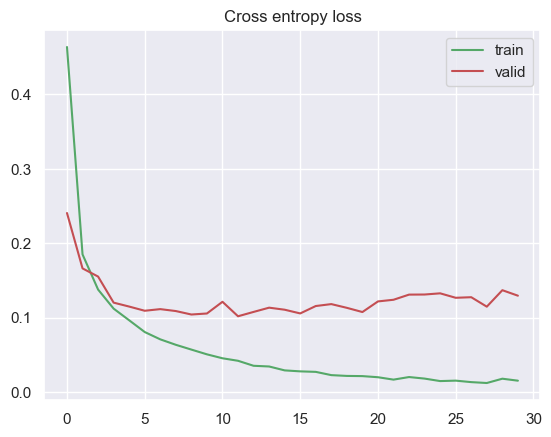

In [109]:
fig = plt.figure()
plt.title("Cross entropy loss")
plt.plot(history["train_loss"], c="g", label="train")
plt.plot(history["val_loss"], c="r", label="valid")
plt.legend()

In [110]:
all_probs = []
all_preds = []
all_targets = []

total_corrects = 0
total_n = 0
modelo16.eval()
for val_instances, val_labels in val_dl:
    val_instances = val_instances.to(device)
    val_labels = val_labels.to(device)

    with torch.no_grad():
        logits = modelo16(val_instances)
    probabilities = nn.functional.softmax(logits, 1)
    all_probs.append(probabilities.cpu())
    preds = torch.argmax(probabilities, 1)

    total_corrects += (preds == val_labels).sum().item()
    total_n += len(val_instances)

    all_preds.append(preds.unsqueeze(-1))
    all_targets.append(val_labels.cpu())


preds = torch.cat(all_preds).cpu()
targets = torch.cat(all_targets).cpu()

print(f"Preds Shape: {preds.shape}")
print(f"Targets Shape: {targets.shape}")

Preds Shape: torch.Size([9000, 1])
Targets Shape: torch.Size([9000])


In [111]:
total_corrects/total_n

0.9714444444444444

Obtivemos tanto loss pior quanto precisão, como não obtivemos nenhum ganho em precisão com regularização de weight decay, optaremos por não utilizar, mantendo as melhores métricas e deixando o modelo mais simples.

### 14o teste

Testaremos outro método de regularização: dropout nas camadas intermediárias, com 50% de chance de um determinado neurônio ser desativado.

In [117]:
class MLPR4(nn.Module):
  def __init__(self, n_classes, droupout_prob=0.5):
    super().__init__()

    self.flatten = nn.Flatten()

    self.dropout = nn.Dropout(droupout_prob)

    # aplicamos o dropout logo após as funçõe de ativação
    self.mlp = nn.Sequential(
        nn.Linear(784, 64),
        nn.ReLU(),
        self.dropout,
        nn.Linear(64, 32),
        nn.ReLU(),
        self.dropout,
        nn.Linear(32, 16),
        nn.ReLU(),
        self.dropout,
        nn.Linear(16, 10)
    )

  def forward(self, x):
    x_flat = self.flatten(x)
    logits = self.mlp(x_flat)
    return logits

In [113]:
history = {
    "train_loss": [],
    "val_loss": []
}

modelo17 = MLPR4(10).to(device)
modelo17.apply(init_weights)

LEARNING_RATE = 0.001
optimizer = optim.Adam(modelo17.parameters(), lr=LEARNING_RATE) # weight_decay removido
EPOCHS = 30

for epoch in range(EPOCHS):
  train_loss = train_step(modelo17, train_dl, loss_fn, optimizer, device)
  val_loss = validation_step(modelo17, val_dl, loss_fn, device)

  history["train_loss"].append(train_loss)
  history["val_loss"].append(val_loss)

  print(f"Época [{epoch + 1}/{EPOCHS}]")
  print("-" * 35)
  print(f"Train loss: {round(train_loss, 6):<7}")
  print(f"Valid. loss: {round(val_loss, 6):<7}\n")

Época [1/30]
-----------------------------------
Train loss: 1.942795
Valid. loss: 1.127557

Época [2/30]
-----------------------------------
Train loss: 1.322684
Valid. loss: 0.666203

Época [3/30]
-----------------------------------
Train loss: 1.091905
Valid. loss: 0.531564

Época [4/30]
-----------------------------------
Train loss: 0.999389
Valid. loss: 0.4851 

Época [5/30]
-----------------------------------
Train loss: 0.936305
Valid. loss: 0.438957

Época [6/30]
-----------------------------------
Train loss: 0.897074
Valid. loss: 0.419674

Época [7/30]
-----------------------------------
Train loss: 0.852658
Valid. loss: 0.399232

Época [8/30]
-----------------------------------
Train loss: 0.823914
Valid. loss: 0.380828

Época [9/30]
-----------------------------------
Train loss: 0.809806
Valid. loss: 0.369699

Época [10/30]
-----------------------------------
Train loss: 0.785557
Valid. loss: 0.375659

Época [11/30]
-----------------------------------
Train loss: 0.771992

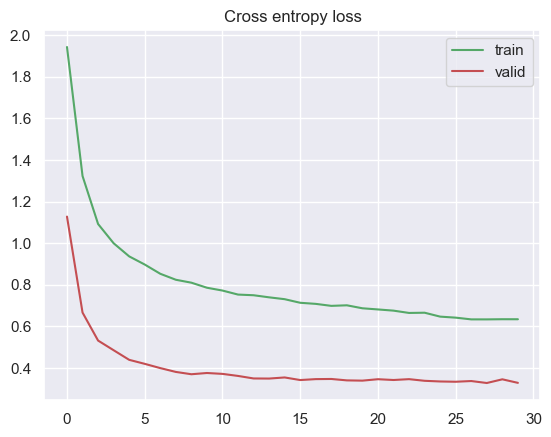

In [114]:
fig = plt.figure()
plt.title("Cross entropy loss")
plt.plot(history["train_loss"], c="g", label="train")
plt.plot(history["val_loss"], c="r", label="valid")
plt.legend()

In [115]:
all_probs = []
all_preds = []
all_targets = []

total_corrects = 0
total_n = 0
modelo17.eval()
for val_instances, val_labels in val_dl:
    val_instances = val_instances.to(device)
    val_labels = val_labels.to(device)

    with torch.no_grad():
        logits = modelo17(val_instances)
    probabilities = nn.functional.softmax(logits, 1)
    all_probs.append(probabilities.cpu())
    preds = torch.argmax(probabilities, 1)

    total_corrects += (preds == val_labels).sum().item()
    total_n += len(val_instances)

    all_preds.append(preds.unsqueeze(-1))
    all_targets.append(val_labels.cpu())


preds = torch.cat(all_preds).cpu()
targets = torch.cat(all_targets).cpu()

print(f"Preds Shape: {preds.shape}")
print(f"Targets Shape: {targets.shape}")

Preds Shape: torch.Size([9000, 1])
Targets Shape: torch.Size([9000])


In [116]:
total_corrects/total_n

0.9415555555555556

Ficamos com métricas piores para o modelo, tentaremos dropout com 30% de chance.

In [118]:
history = {
    "train_loss": [],
    "val_loss": []
}

modelo17 = MLPR4(10, 0.3).to(device)  # dropout_prob = 0.5 -> 0.3
modelo17.apply(init_weights)

LEARNING_RATE = 0.001
optimizer = optim.Adam(modelo17.parameters(), lr=LEARNING_RATE)
EPOCHS = 30

for epoch in range(EPOCHS):
  train_loss = train_step(modelo17, train_dl, loss_fn, optimizer, device)
  val_loss = validation_step(modelo17, val_dl, loss_fn, device)

  history["train_loss"].append(train_loss)
  history["val_loss"].append(val_loss)

  print(f"Época [{epoch + 1}/{EPOCHS}]")
  print("-" * 35)
  print(f"Train loss: {round(train_loss, 6):<7}")
  print(f"Valid. loss: {round(val_loss, 6):<7}\n")

Época [1/30]
-----------------------------------
Train loss: 1.219551
Valid. loss: 0.372678

Época [2/30]
-----------------------------------
Train loss: 0.650747
Valid. loss: 0.267104

Época [3/30]
-----------------------------------
Train loss: 0.529457
Valid. loss: 0.226222

Época [4/30]
-----------------------------------
Train loss: 0.469003
Valid. loss: 0.205163

Época [5/30]
-----------------------------------
Train loss: 0.428314
Valid. loss: 0.194856

Época [6/30]
-----------------------------------
Train loss: 0.395247
Valid. loss: 0.180993

Época [7/30]
-----------------------------------
Train loss: 0.377563
Valid. loss: 0.177425

Época [8/30]
-----------------------------------
Train loss: 0.35649
Valid. loss: 0.17015

Época [9/30]
-----------------------------------
Train loss: 0.335299
Valid. loss: 0.167173

Época [10/30]
-----------------------------------
Train loss: 0.325799
Valid. loss: 0.164915

Época [11/30]
-----------------------------------
Train loss: 0.320956


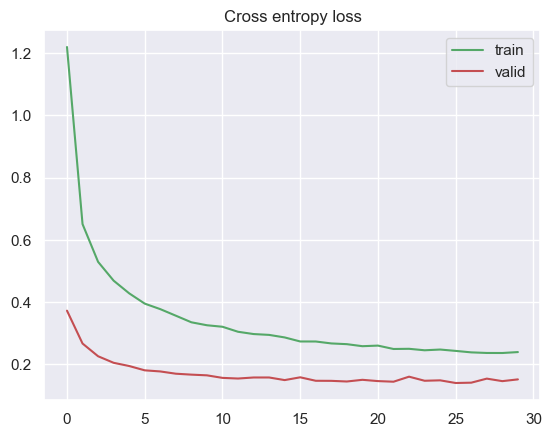

In [119]:
fig = plt.figure()
plt.title("Cross entropy loss")
plt.plot(history["train_loss"], c="g", label="train")
plt.plot(history["val_loss"], c="r", label="valid")
plt.legend()

In [120]:
all_probs = []
all_preds = []
all_targets = []

total_corrects = 0
total_n = 0
modelo17.eval()
for val_instances, val_labels in val_dl:
    val_instances = val_instances.to(device)
    val_labels = val_labels.to(device)

    with torch.no_grad():
        logits = modelo17(val_instances)
    probabilities = nn.functional.softmax(logits, 1)
    all_probs.append(probabilities.cpu())
    preds = torch.argmax(probabilities, 1)

    total_corrects += (preds == val_labels).sum().item()
    total_n += len(val_instances)

    all_preds.append(preds.unsqueeze(-1))
    all_targets.append(val_labels.cpu())


preds = torch.cat(all_preds).cpu()
targets = torch.cat(all_targets).cpu()

print(f"Preds Shape: {preds.shape}")
print(f"Targets Shape: {targets.shape}")

Preds Shape: torch.Size([9000, 1])
Targets Shape: torch.Size([9000])


In [121]:
total_corrects/total_n

0.9616666666666667

Obtivemos uma melhoria em relação ao último teste com dropout, podemos testar agora utilizar uma arquitetura ainda mais complexa, pois com o dropout para ajudar a evitar overfitting, podemos ter algum ganho na capacidade de generalização.

### 15o Teste

In [122]:
class MLPR5(nn.Module):
  def __init__(self, n_classes, droupout_prob=0.5):
    super().__init__()

    self.flatten = nn.Flatten()

    self.dropout = nn.Dropout(droupout_prob)

    # adicionamos uma camada no início, com 128 neurônios
    self.mlp = nn.Sequential(
        nn.Linear(784, 128),
        nn.ReLU(),
        self.dropout,
        nn.Linear(128, 64),
        nn.ReLU(),
        self.dropout,
        nn.Linear(64, 32),
        nn.ReLU(),
        self.dropout,
        nn.Linear(32, 16),
        nn.ReLU(),
        self.dropout,
        nn.Linear(16, 10)
    )

  def forward(self, x):
    x_flat = self.flatten(x)
    logits = self.mlp(x_flat)
    return logits

In [123]:
history = {
    "train_loss": [],
    "val_loss": []
}

modelo18 = MLPR5(10, 0.3).to(device) # mantendo dropout com 30% de chance
modelo18.apply(init_weights)

LEARNING_RATE = 0.001
optimizer = optim.Adam(modelo18.parameters(), lr=LEARNING_RATE)
EPOCHS = 30

for epoch in range(EPOCHS):
  train_loss = train_step(modelo18, train_dl, loss_fn, optimizer, device)
  val_loss = validation_step(modelo18, val_dl, loss_fn, device)

  history["train_loss"].append(train_loss)
  history["val_loss"].append(val_loss)

  print(f"Época [{epoch + 1}/{EPOCHS}]")
  print("-" * 35)
  print(f"Train loss: {round(train_loss, 6):<7}")
  print(f"Valid. loss: {round(val_loss, 6):<7}\n")

Época [1/30]
-----------------------------------
Train loss: 1.317235
Valid. loss: 0.39141

Época [2/30]
-----------------------------------
Train loss: 0.63986
Valid. loss: 0.24572

Época [3/30]
-----------------------------------
Train loss: 0.493065
Valid. loss: 0.20268

Época [4/30]
-----------------------------------
Train loss: 0.418664
Valid. loss: 0.181684

Época [5/30]
-----------------------------------
Train loss: 0.371586
Valid. loss: 0.160841

Época [6/30]
-----------------------------------
Train loss: 0.342587
Valid. loss: 0.163271

Época [7/30]
-----------------------------------
Train loss: 0.319648
Valid. loss: 0.149914

Época [8/30]
-----------------------------------
Train loss: 0.297295
Valid. loss: 0.138736

Época [9/30]
-----------------------------------
Train loss: 0.277603
Valid. loss: 0.14327

Época [10/30]
-----------------------------------
Train loss: 0.270145
Valid. loss: 0.140052

Época [11/30]
-----------------------------------
Train loss: 0.26298
Vali

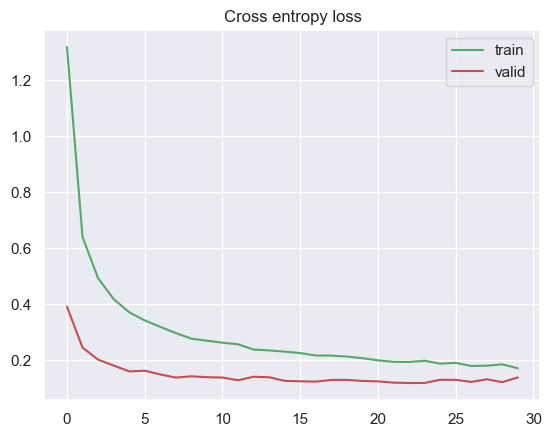

In [124]:
fig = plt.figure()
plt.title("Cross entropy loss")
plt.plot(history["train_loss"], c="g", label="train")
plt.plot(history["val_loss"], c="r", label="valid")
plt.legend()

In [125]:
all_probs = []
all_preds = []
all_targets = []

total_corrects = 0
total_n = 0
modelo18.eval()
for val_instances, val_labels in val_dl:
    val_instances = val_instances.to(device)
    val_labels = val_labels.to(device)

    with torch.no_grad():
        logits = modelo18(val_instances)
    probabilities = nn.functional.softmax(logits, 1)
    all_probs.append(probabilities.cpu())
    preds = torch.argmax(probabilities, 1)

    total_corrects += (preds == val_labels).sum().item()
    total_n += len(val_instances)

    all_preds.append(preds.unsqueeze(-1))
    all_targets.append(val_labels.cpu())


preds = torch.cat(all_preds).cpu()
targets = torch.cat(all_targets).cpu()

print(f"Preds Shape: {preds.shape}")
print(f"Targets Shape: {targets.shape}")

Preds Shape: torch.Size([9000, 1])
Targets Shape: torch.Size([9000])


In [126]:
total_corrects/total_n

0.9731111111111111

Obtivemos um aumento de precisão de mais de 1%, podemos tentar combinar com weight decay para ver se o resultado melhora.

### 16o teste

In [127]:
history = {
    "train_loss": [],
    "val_loss": []
}

modelo19 = MLPR5(10, 0.3).to(device)
modelo19.apply(init_weights)

LEARNING_RATE = 0.001
optimizer = optim.Adam(modelo19.parameters(), lr=LEARNING_RATE, weight_decay=1e-3) # testando com o melhor valor de weight decay que tivemos resultado
EPOCHS = 30

for epoch in range(EPOCHS):
  train_loss = train_step(modelo19, train_dl, loss_fn, optimizer, device)
  val_loss = validation_step(modelo19, val_dl, loss_fn, device)

  history["train_loss"].append(train_loss)
  history["val_loss"].append(val_loss)

  print(f"Época [{epoch + 1}/{EPOCHS}]")
  print("-" * 35)
  print(f"Train loss: {round(train_loss, 6):<7}")
  print(f"Valid. loss: {round(val_loss, 6):<7}\n")

Época [1/30]
-----------------------------------
Train loss: 1.278153
Valid. loss: 0.39918

Época [2/30]
-----------------------------------
Train loss: 0.643771
Valid. loss: 0.248759

Época [3/30]
-----------------------------------
Train loss: 0.497498
Valid. loss: 0.197446

Época [4/30]
-----------------------------------
Train loss: 0.41057
Valid. loss: 0.177027

Época [5/30]
-----------------------------------
Train loss: 0.369968
Valid. loss: 0.165666

Época [6/30]
-----------------------------------
Train loss: 0.335489
Valid. loss: 0.165162

Época [7/30]
-----------------------------------
Train loss: 0.323137
Valid. loss: 0.155718

Época [8/30]
-----------------------------------
Train loss: 0.308218
Valid. loss: 0.137835

Época [9/30]
-----------------------------------
Train loss: 0.29304
Valid. loss: 0.13694

Época [10/30]
-----------------------------------
Train loss: 0.293227
Valid. loss: 0.133403

Época [11/30]
-----------------------------------
Train loss: 0.28355
Val

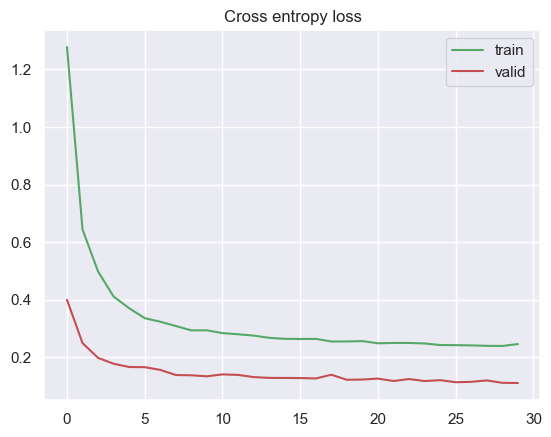

In [128]:
fig = plt.figure()
plt.title("Cross entropy loss")
plt.plot(history["train_loss"], c="g", label="train")
plt.plot(history["val_loss"], c="r", label="valid")
plt.legend()

In [129]:
all_probs = []
all_preds = []
all_targets = []

total_corrects = 0
total_n = 0
modelo19.eval()
for val_instances, val_labels in val_dl:
    val_instances = val_instances.to(device)
    val_labels = val_labels.to(device)

    with torch.no_grad():
        logits = modelo19(val_instances)
    probabilities = nn.functional.softmax(logits, 1)
    all_probs.append(probabilities.cpu())
    preds = torch.argmax(probabilities, 1)

    total_corrects += (preds == val_labels).sum().item()
    total_n += len(val_instances)

    all_preds.append(preds.unsqueeze(-1))
    all_targets.append(val_labels.cpu())


preds = torch.cat(all_preds).cpu()
targets = torch.cat(all_targets).cpu()

print(f"Preds Shape: {preds.shape}")
print(f"Targets Shape: {targets.shape}")

Preds Shape: torch.Size([9000, 1])
Targets Shape: torch.Size([9000])


In [130]:
total_corrects/total_n

0.9727777777777777

Obtivemos uma redução de 0.001 na precisão, talvez não seja tão interessante utilizar weight decay. Tentaremos novamente aumentar a complexidade da arquitetura, já que obtivemos uma boa melhoria com o último aumento.

### 17o teste

In [132]:
class MLPR6(nn.Module):
  def __init__(self, n_classes, droupout_prob=0.5):
    super().__init__()

    self.flatten = nn.Flatten()

    self.dropout = nn.Dropout(droupout_prob)

    # adicionamos mais uma camada no início, com 256 neuronios.
    self.mlp = nn.Sequential(
        nn.Linear(784, 256),
        nn.ReLU(),
        self.dropout,
        nn.Linear(256, 128),
        nn.ReLU(),
        self.dropout,
        nn.Linear(128, 64),
        nn.ReLU(),
        self.dropout,
        nn.Linear(64, 32),
        nn.ReLU(),
        self.dropout,
        nn.Linear(32, 16),
        nn.ReLU(),
        self.dropout,
        nn.Linear(16, 10)
    )

  def forward(self, x):
    x_flat = self.flatten(x)
    logits = self.mlp(x_flat)
    return logits

In [17]:
history = {
    "train_loss": [],
    "val_loss": []
}

modelo20 = MLPR6(10, 0.3).to(device)
modelo20.apply(init_weights)

LEARNING_RATE = 0.001
optimizer = optim.Adam(modelo20.parameters(), lr=LEARNING_RATE)
EPOCHS = 30

for epoch in range(EPOCHS):
  train_loss = train_step(modelo20, train_dl, loss_fn, optimizer, device)
  val_loss = validation_step(modelo20, val_dl, loss_fn, device)

  history["train_loss"].append(train_loss)
  history["val_loss"].append(val_loss)

  print(f"Época [{epoch + 1}/{EPOCHS}]")
  print("-" * 35)
  print(f"Train loss: {round(train_loss, 6):<7}")
  print(f"Valid. loss: {round(val_loss, 6):<7}\n")

NameError: name 'MLPR6' is not defined

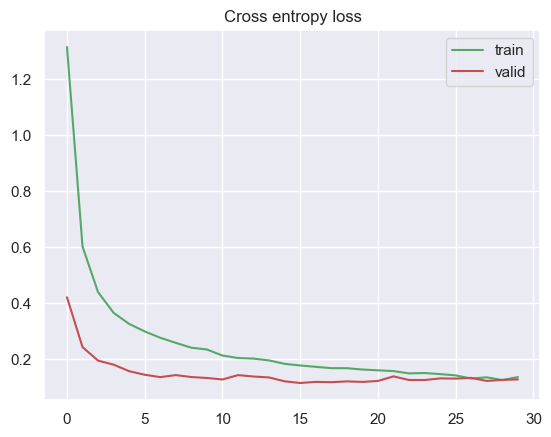

In [142]:
fig = plt.figure()
plt.title("Cross entropy loss")
plt.plot(history["train_loss"], c="g", label="train")
plt.plot(history["val_loss"], c="r", label="valid")
plt.legend()

In [143]:
all_probs = []
all_preds = []
all_targets = []

total_corrects = 0
total_n = 0
modelo20.eval()
for val_instances, val_labels in val_dl:
    val_instances = val_instances.to(device)
    val_labels = val_labels.to(device)

    with torch.no_grad():
        logits = modelo20(val_instances)
    probabilities = nn.functional.softmax(logits, 1)
    all_probs.append(probabilities.cpu())
    preds = torch.argmax(probabilities, 1)

    total_corrects += (preds == val_labels).sum().item()
    total_n += len(val_instances)

    all_preds.append(preds.unsqueeze(-1))
    all_targets.append(val_labels.cpu())


preds = torch.cat(all_preds).cpu()
targets = torch.cat(all_targets).cpu()

print(f"Preds Shape: {preds.shape}")
print(f"Targets Shape: {targets.shape}")

Preds Shape: torch.Size([9000, 1])
Targets Shape: torch.Size([9000])


In [144]:
total_corrects/total_n

0.977

Obtivemos uma melhoria de 0.04 na precisão! Podemos tentar aumentar ainda mais a complexidade.

### 18o teste

In [146]:
class MLPR7(nn.Module):
  def __init__(self, n_classes, droupout_prob=0.5):
    super().__init__()

    self.flatten = nn.Flatten()

    self.dropout = nn.Dropout(droupout_prob)

    # adicionando uma camada de 512 neuronios no começo
    self.mlp = nn.Sequential(
        nn.Linear(784, 512),
        nn.ReLU(),
        self.dropout,
        nn.Linear(512, 256),
        nn.ReLU(),
        self.dropout,
        nn.Linear(256, 128),
        nn.ReLU(),
        self.dropout,
        nn.Linear(128, 64),
        nn.ReLU(),
        self.dropout,
        nn.Linear(64, 32),
        nn.ReLU(),
        self.dropout,
        nn.Linear(32, 16),
        nn.ReLU(),
        self.dropout,
        nn.Linear(16, 10)
    )

  def forward(self, x):
    x_flat = self.flatten(x)
    logits = self.mlp(x_flat)
    return logits

In [147]:
history = {
    "train_loss": [],
    "val_loss": []
}

modelo21 = MLPR6(10, 0.3).to(device)
modelo21.apply(init_weights)

LEARNING_RATE = 0.001
optimizer = optim.Adam(modelo21.parameters(), lr=LEARNING_RATE)
EPOCHS = 30

for epoch in range(EPOCHS):
  train_loss = train_step(modelo21, train_dl, loss_fn, optimizer, device)
  val_loss = validation_step(modelo21, val_dl, loss_fn, device)

  history["train_loss"].append(train_loss)
  history["val_loss"].append(val_loss)

  print(f"Época [{epoch + 1}/{EPOCHS}]")
  print("-" * 35)
  print(f"Train loss: {round(train_loss, 6):<7}")
  print(f"Valid. loss: {round(val_loss, 6):<7}\n")

Época [1/30]
-----------------------------------
Train loss: 1.422267
Valid. loss: 0.473995

Época [2/30]
-----------------------------------
Train loss: 0.618452
Valid. loss: 0.280589

Época [3/30]
-----------------------------------
Train loss: 0.432679
Valid. loss: 0.185419

Época [4/30]
-----------------------------------
Train loss: 0.355637
Valid. loss: 0.160706

Época [5/30]
-----------------------------------
Train loss: 0.303359
Valid. loss: 0.155882

Época [6/30]
-----------------------------------
Train loss: 0.271396
Valid. loss: 0.162442

Época [7/30]
-----------------------------------
Train loss: 0.252636
Valid. loss: 0.151525

Época [8/30]
-----------------------------------
Train loss: 0.230765
Valid. loss: 0.120897

Época [9/30]
-----------------------------------
Train loss: 0.218703
Valid. loss: 0.133102

Época [10/30]
-----------------------------------
Train loss: 0.202467
Valid. loss: 0.129531

Época [11/30]
-----------------------------------
Train loss: 0.19158

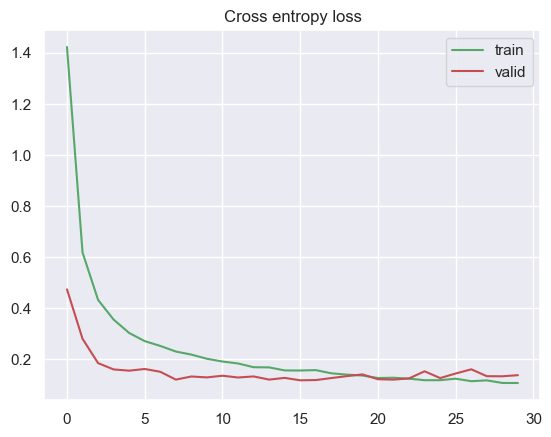

In [148]:
fig = plt.figure()
plt.title("Cross entropy loss")
plt.plot(history["train_loss"], c="g", label="train")
plt.plot(history["val_loss"], c="r", label="valid")
plt.legend()

In [149]:
all_probs = []
all_preds = []
all_targets = []

total_corrects = 0
total_n = 0
modelo21.eval()
for val_instances, val_labels in val_dl:
    val_instances = val_instances.to(device)
    val_labels = val_labels.to(device)

    with torch.no_grad():
        logits = modelo21(val_instances)
    probabilities = nn.functional.softmax(logits, 1)
    all_probs.append(probabilities.cpu())
    preds = torch.argmax(probabilities, 1)

    total_corrects += (preds == val_labels).sum().item()
    total_n += len(val_instances)

    all_preds.append(preds.unsqueeze(-1))
    all_targets.append(val_labels.cpu())


preds = torch.cat(all_preds).cpu()
targets = torch.cat(all_targets).cpu()

print(f"Preds Shape: {preds.shape}")
print(f"Targets Shape: {targets.shape}")

Preds Shape: torch.Size([9000, 1])
Targets Shape: torch.Size([9000])


In [150]:
total_corrects/total_n

0.9807777777777777

Obtivemos outra melhoria na precisão, podemos tentar aumentar a complexidade novamente.

In [10]:
class MLPR8(nn.Module):
  def __init__(self, n_classes, droupout_prob=0.5):
    super().__init__()

    self.flatten = nn.Flatten()

    self.dropout = nn.Dropout(droupout_prob)

    # adicionando uma camada de 512 neuronios no começo
    self.mlp = nn.Sequential(
        nn.Linear(784, 1024),
        nn.ReLU(),
        self.dropout,
        nn.Linear(1024, 512),
        nn.ReLU(),
        self.dropout,
        nn.Linear(512, 256),
        nn.ReLU(),
        self.dropout,
        nn.Linear(256, 128),
        nn.ReLU(),
        self.dropout,
        nn.Linear(128, 64),
        nn.ReLU(),
        self.dropout,
        nn.Linear(64, 32),
        nn.ReLU(),
        self.dropout,
        nn.Linear(32, 16),
        nn.ReLU(),
        self.dropout,
        nn.Linear(16, 10)
    )

  def forward(self, x):
    x_flat = self.flatten(x)
    logits = self.mlp(x_flat)
    return logits

In [20]:
history = {
    "train_loss": [],
    "val_loss": []
}

modelo23 = MLPR8(10, droupout_prob=0.3).to(device)
modelo23.apply(init_weights)

LEARNING_RATE = 0.001
optimizer = optim.Adam(modelo23.parameters(), lr=LEARNING_RATE)
EPOCHS = 30

for epoch in range(EPOCHS):
  train_loss = train_step(modelo23, train_dl, loss_fn, optimizer, device)
  val_loss = validation_step(modelo23, val_dl, loss_fn, device)

  history["train_loss"].append(train_loss)
  history["val_loss"].append(val_loss)

  print(f"Época [{epoch + 1}/{EPOCHS}]")
  print("-" * 35)
  print(f"Train loss: {round(train_loss, 6):<7}")
  print(f"Valid. loss: {round(val_loss, 6):<7}\n")

Época [1/30]
-----------------------------------
Train loss: 1.470415
Valid. loss: 0.425766

Época [2/30]
-----------------------------------
Train loss: 0.615616
Valid. loss: 0.234583

Época [3/30]
-----------------------------------
Train loss: 0.448425
Valid. loss: 0.194069

Época [4/30]
-----------------------------------
Train loss: 0.358299
Valid. loss: 0.172114

Época [5/30]
-----------------------------------
Train loss: 0.308933
Valid. loss: 0.168047

Época [6/30]
-----------------------------------
Train loss: 0.284502
Valid. loss: 0.168932

Época [7/30]
-----------------------------------
Train loss: 0.250263
Valid. loss: 0.174071

Época [8/30]
-----------------------------------
Train loss: 0.231873
Valid. loss: 0.154986

Época [9/30]
-----------------------------------
Train loss: 0.217609
Valid. loss: 0.155695

Época [10/30]
-----------------------------------
Train loss: 0.206406
Valid. loss: 0.149285

Época [11/30]
-----------------------------------
Train loss: 0.18432

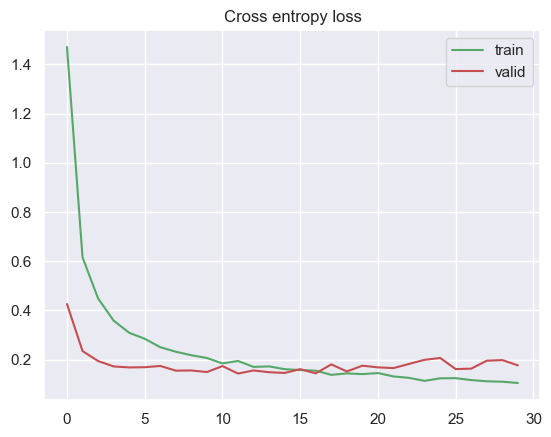

In [21]:
fig = plt.figure()
plt.title("Cross entropy loss")
plt.plot(history["train_loss"], c="g", label="train")
plt.plot(history["val_loss"], c="r", label="valid")
plt.legend()

In [22]:
all_probs = []
all_preds = []
all_targets = []

total_corrects = 0
total_n = 0
modelo23.eval()
for val_instances, val_labels in val_dl:
    val_instances = val_instances.to(device)
    val_labels = val_labels.to(device)

    with torch.no_grad():
        logits = modelo23(val_instances)
    probabilities = nn.functional.softmax(logits, 1)
    all_probs.append(probabilities.cpu())
    preds = torch.argmax(probabilities, 1)

    total_corrects += (preds == val_labels).sum().item()
    total_n += len(val_instances)

    all_preds.append(preds.unsqueeze(-1))
    all_targets.append(val_labels.cpu())


preds = torch.cat(all_preds).cpu()
targets = torch.cat(all_targets).cpu()

print(f"Preds Shape: {preds.shape}")
print(f"Targets Shape: {targets.shape}")

Preds Shape: torch.Size([9000, 1])
Targets Shape: torch.Size([9000])


In [23]:
total_corrects/total_n

0.9822222222222222

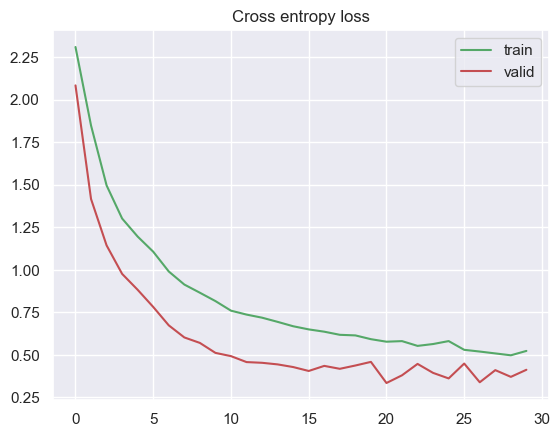

In [180]:
fig = plt.figure()
plt.title("Cross entropy loss")
plt.plot(history["train_loss"], c="g", label="train")
plt.plot(history["val_loss"], c="r", label="valid")
plt.legend()

Conseguimos mais uma melhoria, dessa vez de 98.07% para 98.22%, uma diminuição de cerca de 8% no erro. Como não estamos obtendo mais ganhos relevantes melhorando a arquitetura, podemos tentar novamente alterar a taxa de dropout, tentaremos usar essa mesma arquitetura, com um dropout de 50%.

### 19o teste

In [24]:
history = {
    "train_loss": [],
    "val_loss": []
}

modelo24 = MLPR8(10).to(device) # quando removemos o parametro, ele utiliza o dropout de 50%
modelo24.apply(init_weights)

LEARNING_RATE = 0.001
optimizer = optim.Adam(modelo24.parameters(), lr=LEARNING_RATE)
EPOCHS = 30

for epoch in range(EPOCHS):
  train_loss = train_step(modelo24, train_dl, loss_fn, optimizer, device)
  val_loss = validation_step(modelo24, val_dl, loss_fn, device)

  history["train_loss"].append(train_loss)
  history["val_loss"].append(val_loss)

  print(f"Época [{epoch + 1}/{EPOCHS}]")
  print("-" * 35)
  print(f"Train loss: {round(train_loss, 6):<7}")
  print(f"Valid. loss: {round(val_loss, 6):<7}\n")

Época [1/30]
-----------------------------------
Train loss: 2.37148
Valid. loss: 2.301684

Época [2/30]
-----------------------------------
Train loss: 2.277247
Valid. loss: 2.190786

Época [3/30]
-----------------------------------
Train loss: 2.099439
Valid. loss: 1.917725

Época [4/30]
-----------------------------------
Train loss: 1.95336
Valid. loss: 1.823204

Época [5/30]
-----------------------------------
Train loss: 1.79627
Valid. loss: 1.588177

Época [6/30]
-----------------------------------
Train loss: 1.696229
Valid. loss: 1.53834

Época [7/30]
-----------------------------------
Train loss: 1.619413
Valid. loss: 1.463459

Época [8/30]
-----------------------------------
Train loss: 1.50362
Valid. loss: 1.350404

Época [9/30]
-----------------------------------
Train loss: 1.352422
Valid. loss: 1.166599

Época [10/30]
-----------------------------------
Train loss: 1.295962
Valid. loss: 1.127805

Época [11/30]
-----------------------------------
Train loss: 1.238094
Val

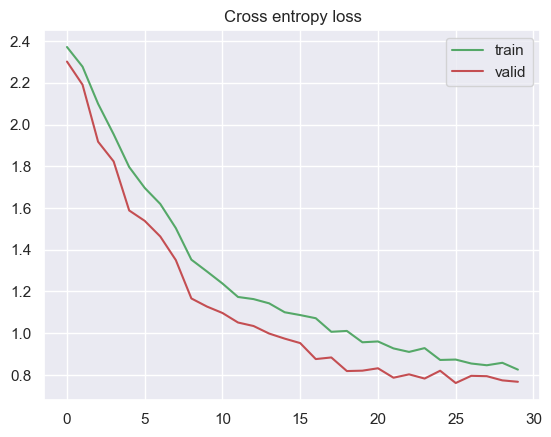

In [25]:
fig = plt.figure()
plt.title("Cross entropy loss")
plt.plot(history["train_loss"], c="g", label="train")
plt.plot(history["val_loss"], c="r", label="valid")
plt.legend()

In [26]:
all_probs = []
all_preds = []
all_targets = []

total_corrects = 0
total_n = 0
modelo24.eval()
for val_instances, val_labels in val_dl:
    val_instances = val_instances.to(device)
    val_labels = val_labels.to(device)

    with torch.no_grad():
        logits = modelo24(val_instances)
    probabilities = nn.functional.softmax(logits, 1)
    all_probs.append(probabilities.cpu())
    preds = torch.argmax(probabilities, 1)

    total_corrects += (preds == val_labels).sum().item()
    total_n += len(val_instances)

    all_preds.append(preds.unsqueeze(-1))
    all_targets.append(val_labels.cpu())


preds = torch.cat(all_preds).cpu()
targets = torch.cat(all_targets).cpu()

print(f"Preds Shape: {preds.shape}")
print(f"Targets Shape: {targets.shape}")

Preds Shape: torch.Size([9000, 1])
Targets Shape: torch.Size([9000])


In [27]:
total_corrects/total_n

0.7432222222222222

Obtivemos uma precisão muito inferior em relação ao modelo anterior, por isso, escolheremos ele como modelo definitivo.

### Testando o modelo

In [28]:
all_probs = []
all_preds = []
all_targets = []
wrong_preds = []

total_corrects = 0
total_n = 0
modelo23.eval()
for val_instances, val_labels in test_dl:
    val_instances = val_instances.to(device)
    val_labels = val_labels.to(device)

    with torch.no_grad():
        logits = modelo23(val_instances)
    probabilities = nn.functional.softmax(logits, 1)
    preds = torch.argmax(probabilities, 1)
    
    corrects = preds == val_labels
    incorrect_indices = ~corrects

    total_corrects += corrects.sum().item()
    total_n += len(val_instances)

    all_probs.append(probabilities.cpu())
    all_preds.append(preds.unsqueeze(-1))
    all_targets.append(val_labels.cpu())

    # salvando as imagens erradas para mostrá-las posteriormente
    for idx in incorrect_indices.nonzero(as_tuple=True)[0]:
        img = val_instances[idx].cpu()
        pred_label = preds[idx].item()
        true_label = val_labels [idx].item()
        wrong_preds.append((img, pred_label, true_label))
        


preds = torch.cat(all_preds).cpu()
targets = torch.cat(all_targets).cpu()

print(f"Preds Shape: {preds.shape}")
print(f"Targets Shape: {targets.shape}")

Preds Shape: torch.Size([10000, 1])
Targets Shape: torch.Size([10000])


Conseguimos uma precisão de 98.17% no conjunto de treino.

In [29]:
total_corrects/total_n

0.9817

Erramos a classificação de apenas de 183 imagens, de um total de 10000!

In [36]:
len(wrong_preds)

183

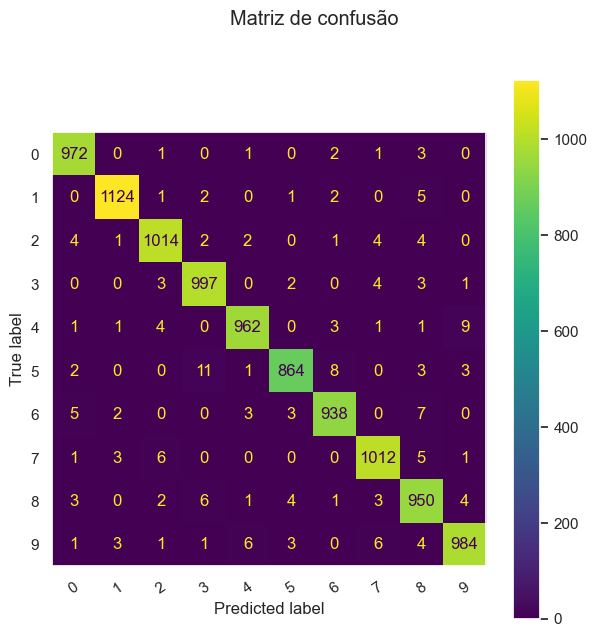

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
fig.suptitle("Matriz de confusão")
ax.grid(False)

labels = list(str(i) for i in range(10))

cm = confusion_matrix(targets, preds)
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels)
cm_display.plot(ax=ax, xticks_rotation=35.0)

Não notamos nenhuma anomalia na matriz de confusão.

In [37]:
print(classification_report(targets, preds, target_names=labels, zero_division=0, digits=3))

              precision    recall  f1-score   support

           0      0.983     0.992     0.987       980
           1      0.991     0.990     0.991      1135
           2      0.983     0.983     0.983      1032
           3      0.978     0.987     0.983      1010
           4      0.986     0.980     0.983       982
           5      0.985     0.969     0.977       892
           6      0.982     0.979     0.981       958
           7      0.982     0.984     0.983      1028
           8      0.964     0.975     0.970       974
           9      0.982     0.975     0.979      1009

    accuracy                          0.982     10000
   macro avg      0.982     0.981     0.981     10000
weighted avg      0.982     0.982     0.982     10000



Métricas finais:
- Precisão média de 98.2%
- recall médio de 98.1%
- f1-score médio de 98.1%

Salvando o modelo

In [33]:
torch.save(modelo23.state_dict(), 'projects/MLP-digits-classifier/final_model.pth')

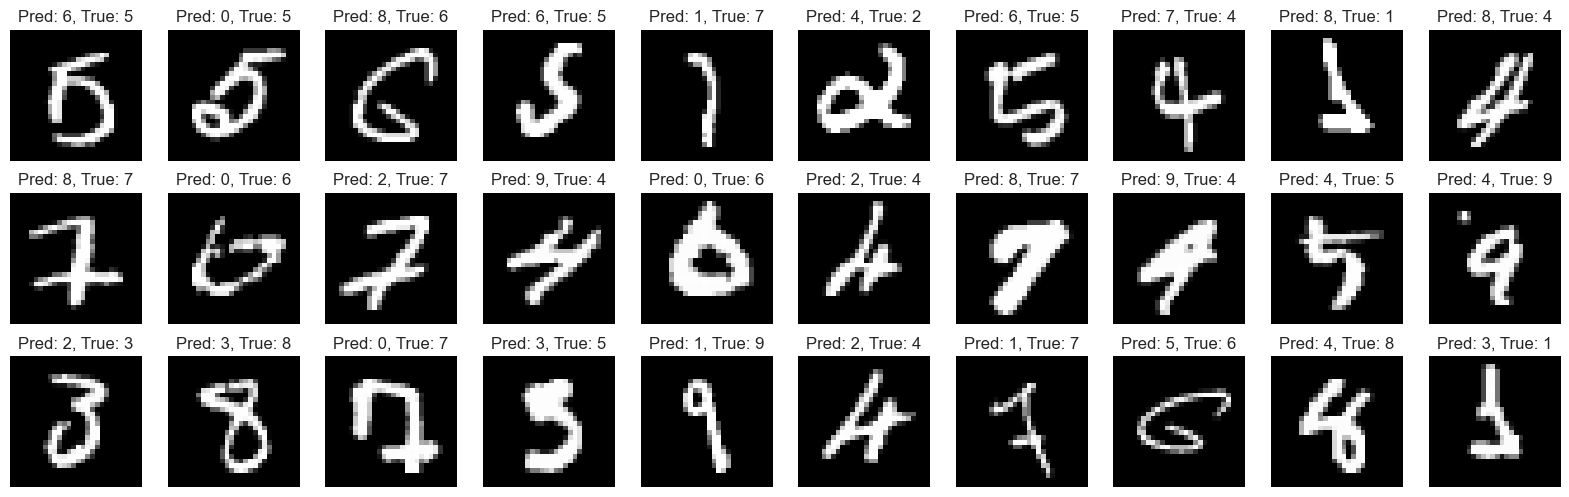

In [34]:
def plot_wrong_predictions(wrong_preds, num_images=30):
    num_images = min(num_images, len(wrong_preds))
    num_cols = 10
    num_rows = 3

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 6))
    axes = axes.flatten()

    for i in range(num_images):
        img, pred, true = wrong_preds[i]
        ax = axes[i]
        ax.imshow(img.squeeze(), cmap='gray')  # Adjust depending on your data format
        ax.set_title(f"Pred: {pred}, True: {true}")
        ax.axis('off')

    # Hide any unused axes if there are less than num_images wrong predictions
    for j in range(i + 1, num_rows * num_cols):
        axes[j].axis('off')

    plt.show()

# Call the function to display wrong predictions
plot_wrong_predictions(wrong_preds)


Visualizando os erros, temos alguns erros aceitáveis, como a 5a imagem na primeira fileira, ou a 7a imagem na segunda linha, são erros que humanos também poderiam cometer, mas também temos erros que o modelo provavelmente não deveria estar cometendo, como a primeira imagem da terceira fileira.